In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [18]:
def create_mask(h, w, NA, lambda_,):
    center = (int(w/2), int(h/2))
    y, x = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
    mask = dist_from_center <= (NA / lambda_) ** 2
    mask = mask * 1.
    return mask

In [19]:
create_mask(5, 5, 2, 1)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [309]:
class OpticsBasedBlur():
    def __init__(self):
        self.device = 'cuda'

    def _distance_from_center(self, index, length):
        return abs(index - length // 2)

    def distance(self, length):
        distance = torch.zeros(length)
        for idx in range(length):
            distance[idx] = self._distance_from_center(idx, length)
        return distance.to(self.device)
        
    def gen_distance_plane(self, xlen, ylen):
        xd = self.distance(xlen)
        yd = self.distance(ylen)
        xp = xd.expand(ylen, xlen)
        yp = yd.expand(xlen, ylen).transpose(1, 0)
        dp = xp ** 2 + yp ** 2
        return dp
    
    def defocus_aberration(self, dp, n_i, lambda_):
        dp = torch.complex(dp, torch.zeros_like(dp))
        w_def_z = 2 * torch.pi / lambda_ \
                * ((n_i ** 2 - lambda_ ** 2 * (dp)) ** 0.5 - n_i)
        return w_def_z  # =  w_def / z
   
    def w_def(self, w_def_z, z_d):
        z_d_len = z_d.shape
        w_def_z = w_def_z.unsqueeze(0).expand(*z_d_len, *w_def_z.shape)
        z_d = z_d.view(*z_d.shape, 1, 1)  
        w_def = w_def_z * z_d
        return w_def

    def pupil_function(self, dp, w_def, lambda_, a, ):
        mask = dp <= (a / lambda_) ** 2
        j_w_def = torch.tensor([0 + 1j], device=self.device) * w_def
        return torch.exp(j_w_def) * mask
    
    def asf(self, pupil_function):
        asf = torch.fft.fft2(pupil_function)
        return torch.fft.fftshift(asf)
    
    def psf(self, asf):
        return (asf.abs()) ** 2

    def main(self, xlen, ylen, n_i, lambda_, z, a):
        dp = self.gen_distance_plane(xlen, ylen)#;print('dp', dp)
        w_def_z = self.defocus_aberration(dp, n_i, lambda_)#;print('w_def_z', w_def_z)
        z_d = self.distance(z)
        w_def = self.w_def(w_def_z, z_d)#;print('w_def', w_def)
        pf = self.pupil_function(dp, w_def, lambda_, a)#;print('pf', pf)
        asf = self.asf(pf)#;print('asf', asf)
        return (self.psf(asf)) ** 2

In [310]:
blur = OpticsBasedBlur()

In [315]:
a = blur.main(xlen = 41,
              ylen = 41,
              n_i  = 1.3,
              lambda_ = 0.900,
              z = 101,
              a = 0.95)

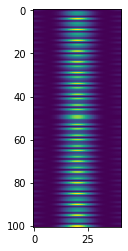

In [316]:
plt.imshow(a.to('cpu').numpy()[:, 13, :])